Found 10042 images belonging to 2 classes.
Found 2154 images belonging to 2 classes.
Found 2152 images belonging to 2 classes.
Epoch 1/10
1256/1256 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.8223
Epoch 1: val_loss improved from inf to 0.33314, saving model to ResNet50.keras
1256/1256 [==============================] - 368s 288ms/step - loss: 0.4091 - accuracy: 0.8223 - val_loss: 0.3331 - val_accuracy: 0.8709
Epoch 2/10
1256/1256 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.8629
Epoch 2: val_loss improved from 0.33314 to 0.23630, saving model to ResNet50.keras
1256/1256 [==============================] - 422s 336ms/step - loss: 0.3228 - accuracy: 0.8629 - val_loss: 0.2363 - val_accuracy: 0.8932
Epoch 3/10
1256/1256 [==============================] - ETA: 0s - loss: 0.2857 - accuracy: 0.8787
Epoch 3: val_loss did not improve from 0.23630
1256/1256 [==============================] - 503s 400ms/step - loss: 0.2857 - accuracy: 0.8787 -

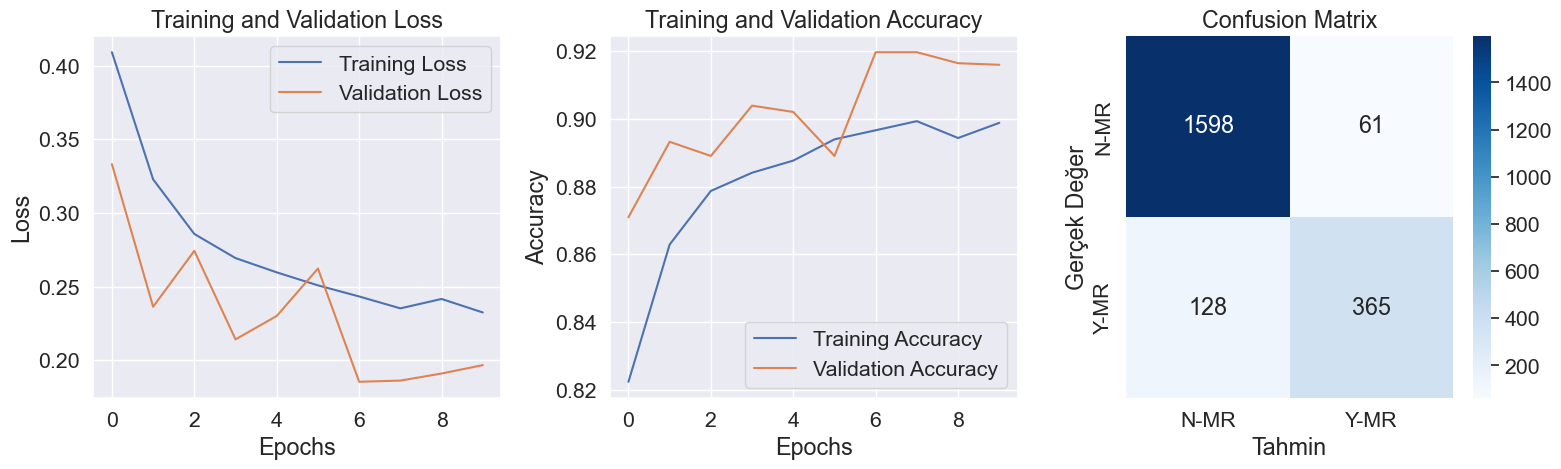


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1659
           1       0.86      0.74      0.79       493

    accuracy                           0.91      2152
   macro avg       0.89      0.85      0.87      2152
weighted avg       0.91      0.91      0.91      2152



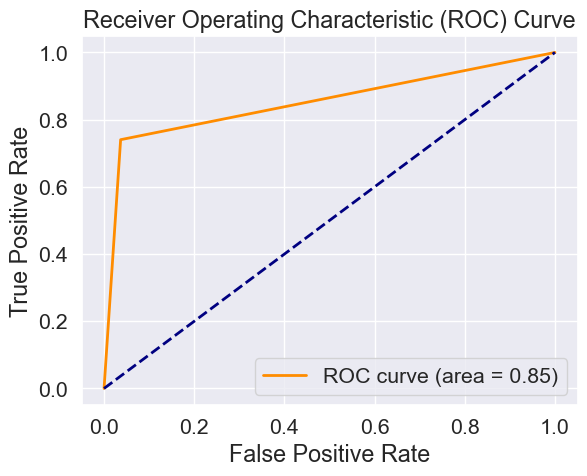

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Early stopping callback'i oluşturma
early_stopping = EarlyStopping(
    monitor='val_loss',  # Takip edilecek metrik (örneğin, doğrulama kaybı)
    patience=3,  # Metrik iyileşmediğinde veya durduğunda beklenen epoch sayısı
    restore_best_weights=True  # En iyi ağırlıkları geri yükleme
)

# Define image dataset
# why do we rescale?
WIDTH, HEIGHT = 128, 128
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0, shear_range=0.25, horizontal_flip=True, rotation_range=20)

train_dataset = image_generator.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\train",
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

image_generator_submission = ImageDataGenerator(rescale=1/255, validation_split=0.5)
validation = image_generator_submission.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

test_dataset = image_generator_submission.flow_from_directory(
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="validation",
    class_mode=None
)

# ResNet50 modelini yükleme
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))

# Yeni model oluşturma
model = Sequential([
    resnet50_model,  # ResNet50 modelini ekliyoruz
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.num_classes, activation='softmax')
])

# Katmanları dondurma
for layer in resnet50_model.layers:
    layer.trainable = False

# Modeli derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model eğitimi
history = model.fit(train_dataset, epochs=10, validation_data=validation, callbacks=[early_stopping, resnet50_checkpoint])

# Eğitim ve doğrulama kaybı ve doğruluğu görselleştirme
plt.figure(figsize=(16, 5))

# Eğitim ve doğrulama kaybı
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Confusion Matrix
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true = test_dataset.labels
conf_matrix = confusion_matrix(y_true, y_pred)

# Karışıklık matrisini görselleştirme
plt.subplot(1, 3, 3)
sns.set(font_scale=1.4)  # Font ölçeğini ayarla
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['N-MR', 'Y-MR'],
            yticklabels=['N-MR', 'Y-MR'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek Değer')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)

# ROC Eğrisi ve AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()

resnet50_checkpoint = ModelCheckpoint('ResNet50.keras', verbose=1, save_best_only=True)


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define image dataset
WIDTH, HEIGHT = 128, 128
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0, shear_range=0.25, horizontal_flip=True, rotation_range=20)

train_dataset = image_generator.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\train",
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

image_generator_submission = ImageDataGenerator(rescale=1/255, validation_split=0.5)
validation = image_generator_submission.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

test_dataset = image_generator_submission.flow_from_directory(
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="validation",
    class_mode=None
)



Found 10042 images belonging to 2 classes.
Found 2154 images belonging to 2 classes.
Found 2152 images belonging to 2 classes.


68/68 [==============================] - 83s 1s/step


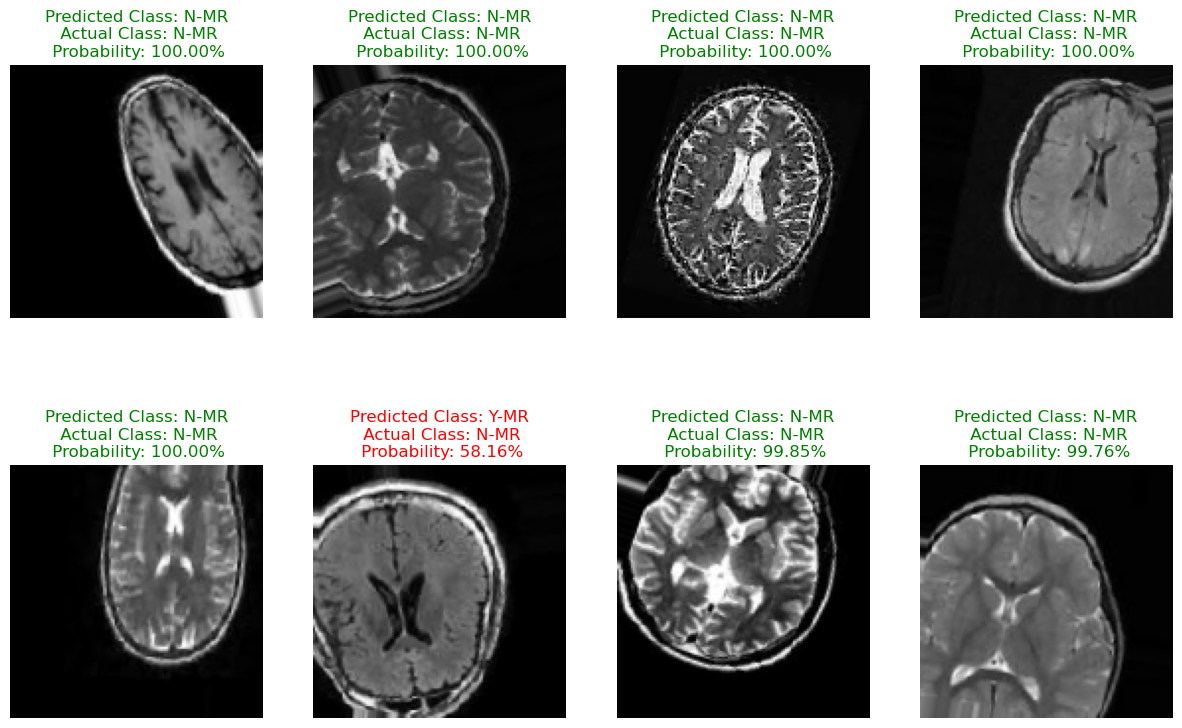

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model


resnet50_model=load_model("ResNet50.keras")




resnet50_predictions=resnet50_model.predict(test_dataset)




resnet50_true_classes=test_dataset.classes

categories={0:'N-MR', 1:'Y-MR'}
resnet50_predicted_classes = np.argmax(resnet50_predictions, axis=1)

predicted_classes = np.argmax(resnet50_predictions, axis=1)  # En yüksek olasılığa sahip sınıfları al
prediction_probabilities = np.max(resnet50_predictions, axis=1)  # En yüksek olasılıkları al
batch_1_img = train_dataset[0]
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(5,4,i+1)
    plt.imshow(batch_1_img[0][i])
    predicted_class_label=categories[resnet50_predicted_classes[i]]
    actual_class_label=categories[resnet50_true_classes[i]]

    if resnet50_predicted_classes[i] == resnet50_true_classes[i]:
        title_color='green'
    else:
        title_color='red'

    prediction_probability = prediction_probabilities[i] * 100

    title = f'Predicted Class: {predicted_class_label}\n Actual Class: {actual_class_label}\n Probability: {prediction_probability:.2f}%'
    plt.title(title,color=title_color)
    plt.axis('off')
plt.subplots_adjust(top=1.4)
plt.show()